In [1]:
import os

import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import joblib

from tensorflow import keras
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

In [2]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix

from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_evaluations
from skopt import gp_minimize

In [3]:
import helper_functions.plotting_functions as plotting_functions
import helper_functions.data_functions as data_functions
import helper_functions.config as config

In [4]:
print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print(f"SciKit Learn {sklearn.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.1.0
Keras 2.2.4-tf
SciKit Learn 0.22.1

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


In [5]:
data_file = config.training_data_file

features = config.features
features_to_scale = config.features_to_scale
months = config.months

left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = config.fig_rows
fig_cols = config.fig_cols
plot_height = config.plot_height
plot_width = config.plot_width
plot_locations = config.plot_locations

metrics = config.metrics

In [6]:
# Load data
raw_data = pd.read_parquet(data_file)

# Pull out columns of intrest
data = raw_data[features]

# Pick one spatial bin with fires
data = data[(data['lat'] == 39.42233) & (data['lon'] == -120.6546)]

num_fires = data['ignition'].sum()
total_observations = len(data)

print("Num fires: "+str(num_fires))
print("Total obervations: "+str(total_observations))

# convert ignition to int
data['ignition'] = data['ignition'].astype('int32')

# Also drop lat, lon, columns (unnecessary)
data.drop(['lat', 'lon'], axis=1, inplace=True)

data.reset_index(inplace=True, drop=True)
data.head()

Num fires: 716.0
Total obervations: 8766


,mean_air_2m,mean_apcp,mean_rhum_2m,mean_dpt_2m,mean_pres_sfc,mean_uwnd_10m,mean_vwnd_10m,mean_cloud_cover,veg,crain,ignition,date
0,272.066956,0.000000,54.349842,263.759735,82468.335938,-2.419784,3.027377,1.625000,70.699997,0.000,0,1992-01-01
1,273.152374,0.000343,46.536934,262.851501,82450.710938,-1.904384,3.347039,1.880208,70.699997,0.000,0,1992-01-02
2,274.637451,0.020557,43.627312,263.381226,81925.929688,-1.495060,1.557715,13.437500,70.699997,0.000,0,1992-01-03
3,273.870850,0.898149,73.530479,269.089813,81348.601562,1.027952,6.304882,50.510418,70.699997,0.000,0,1992-01-04
4,273.817963,2.706949,93.832382,272.896027,81021.375000,1.164567,11.754253,66.333336,70.699997,0.125,0,1992-01-05


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   mean_air_2m       8766 non-null   float32       
 1   mean_apcp         8766 non-null   float32       
 2   mean_rhum_2m      8766 non-null   float32       
 3   mean_dpt_2m       8766 non-null   float32       
 4   mean_pres_sfc     8766 non-null   float32       
 5   mean_uwnd_10m     8766 non-null   float32       
 6   mean_vwnd_10m     8766 non-null   float32       
 7   mean_cloud_cover  8766 non-null   float32       
 8   veg               8766 non-null   float32       
 9   crain             8766 non-null   float32       
 10  ignition          8766 non-null   int32         
 11  date              8766 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float32(10), int32(1)
memory usage: 445.3 KB


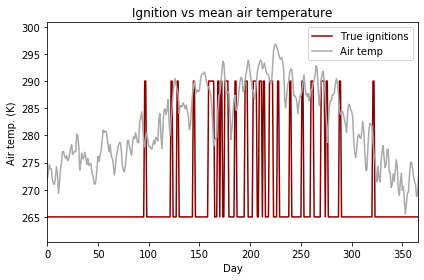

In [8]:
plotting_functions.data_diagnostic_plot(data, 'mean_air_2m', 25, 265)

In [9]:
onehot_encoder = OneHotEncoder(sparse=False)
month = np.array(pd.DatetimeIndex(data['date']).month).reshape(-1, 1)
month = month.astype('int32')
onehot_month = onehot_encoder.fit_transform(month).astype('int32')
onehot_month_df = pd.DataFrame(onehot_month, columns = months)
onehot_month_df.reset_index(drop = True, inplace = True)
onehot_month_df = onehot_month_df.astype('int32')
data.reset_index(drop = True, inplace = True)
data = pd.concat([data, onehot_month_df], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   mean_air_2m       8766 non-null   float32       
 1   mean_apcp         8766 non-null   float32       
 2   mean_rhum_2m      8766 non-null   float32       
 3   mean_dpt_2m       8766 non-null   float32       
 4   mean_pres_sfc     8766 non-null   float32       
 5   mean_uwnd_10m     8766 non-null   float32       
 6   mean_vwnd_10m     8766 non-null   float32       
 7   mean_cloud_cover  8766 non-null   float32       
 8   veg               8766 non-null   float32       
 9   crain             8766 non-null   float32       
 10  ignition          8766 non-null   int32         
 11  date              8766 non-null   datetime64[ns]
 12  February          8766 non-null   int32         
 13  November          8766 non-null   int32         
 14  August            8766 n

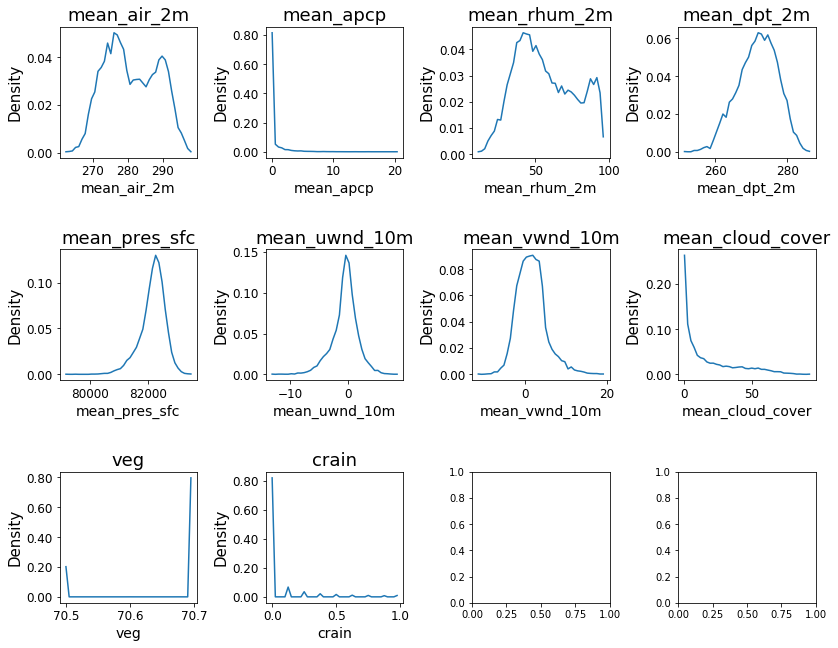

In [10]:
xlabels = features_to_scale
ylabels = ['Density'] * len(features_to_scale)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(features_to_scale)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        data, 
        features_to_scale[i], 
        features_to_scale[i], 
        features_to_scale[i], 
        ylabels[i]
    )

In [11]:
qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
normalized_data = pd.DataFrame(qt.fit_transform(data[features_to_scale]), columns=features_to_scale)
data[features_to_scale] = normalized_data

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = scaler.fit_transform(data[features_to_scale])
data[features_to_scale] = scaled_features

data[features_to_scale] = data[features_to_scale].astype('float32')

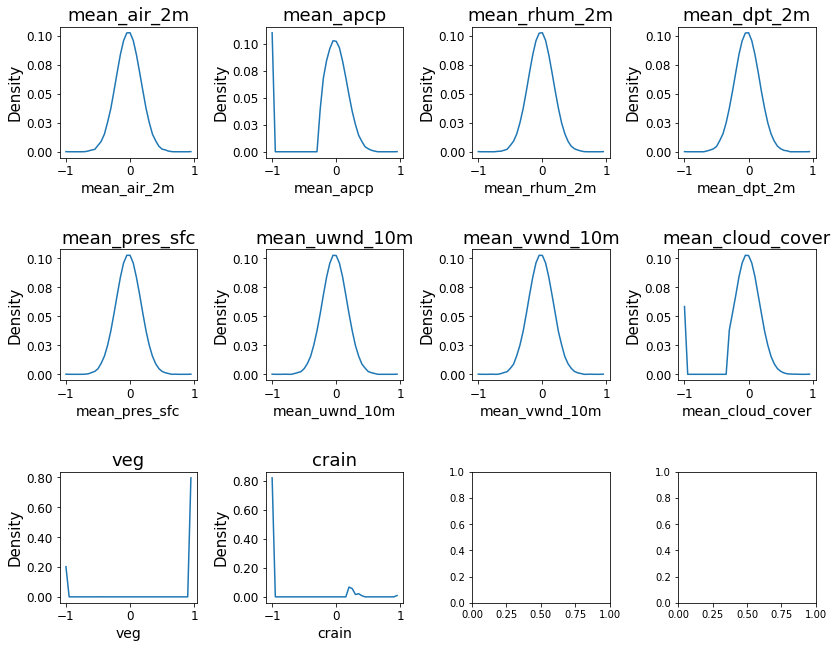

In [12]:
xlabels = features_to_scale
ylabels = ['Density'] * len(features_to_scale)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(features_to_scale)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        data, 
        features_to_scale[i], 
        features_to_scale[i], 
        features_to_scale[i], 
        ylabels[i]
    )
    
plt.show()

In [13]:
# Split data up into training, testing and validation sets
test_data = data.tail(int(len(data)*0.25))
leftover_data = data.head(int(len(data)*0.75))
validation_data = data.tail(int(len(leftover_data)*0.5))
training_data = data.head(int(len(leftover_data)*0.5))

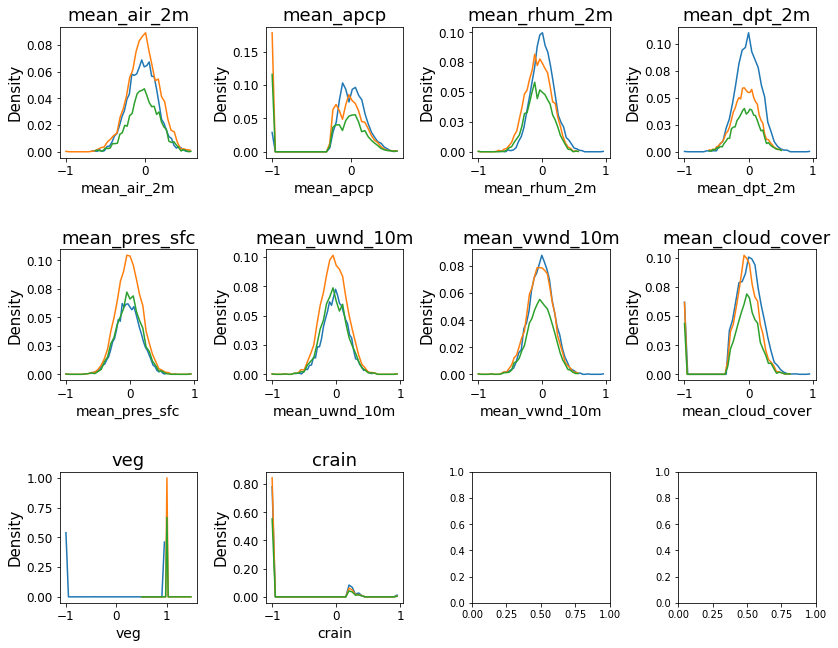

In [14]:
xlabels = features_to_scale
ylabels = ['Density'] * len(features_to_scale)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(features_to_scale)):
    ax[plot_locations[i]] = plotting_functions.three_sample_density_plot(
        ax,
        plot_locations[i], 
        training_data, 
        validation_data, 
        test_data, 
        features_to_scale[i], 
        features_to_scale[i], 
        features_to_scale[i], 
        ylabels[i]
    )
    
plt.show()

In [15]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   mean_air_2m       3287 non-null   float32       
 1   mean_apcp         3287 non-null   float32       
 2   mean_rhum_2m      3287 non-null   float32       
 3   mean_dpt_2m       3287 non-null   float32       
 4   mean_pres_sfc     3287 non-null   float32       
 5   mean_uwnd_10m     3287 non-null   float32       
 6   mean_vwnd_10m     3287 non-null   float32       
 7   mean_cloud_cover  3287 non-null   float32       
 8   veg               3287 non-null   float32       
 9   crain             3287 non-null   float32       
 10  ignition          3287 non-null   int32         
 11  date              3287 non-null   datetime64[ns]
 12  February          3287 non-null   int32         
 13  November          3287 non-null   int32         
 14  August            3287 n

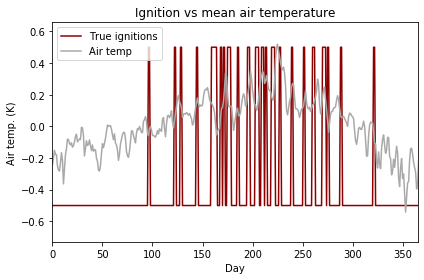

In [16]:
plotting_functions.data_diagnostic_plot(training_data, 'mean_air_2m', 1, -0.5)

### First, let's try and over fit the crap out of it with a 100 unit LSTM. We will use Gaussian process minimization to optimize the learning rate, past history and class weights. Loss function is binary cross entropy. Minimization and early stopping will use Matthews correlation coefficient.

In [17]:
metrics = [
    keras.metrics.TruePositives(name='true_positives'),
    keras.metrics.FalsePositives(name='false_positives'),
    keras.metrics.TrueNegatives(name='true_negatives'),
    keras.metrics.FalseNegatives(name='false_negatives'), 
    keras.metrics.AUC(name='auc'),
    data_functions.matthews_correlation
]

dim_learning_rate = Real(
    low=0.0001,
    high=0.1, 
    name='learning_rate'
)

dim_past_history = Integer(
    low=1,
    high=5, 
    name='past_history'
)

dim_class_0_weight = Real(
    low=0.001, 
    high=10,
    name='class_0_weight'
)

dim_class_1_weight = Real(
    low=0.01, 
    high=100,
    name='class_1_weight'
)

dimensions = [
    dim_learning_rate,
    dim_past_history,
    dim_class_0_weight,
    dim_class_1_weight
]

inital_class_0_weight = (1 / (total_observations - num_fires))*(total_observations)/2.0 
inital_class_1_weight = (1 / num_fires)*(total_observations)/2.0

default_parameters = [0.1, 1, inital_class_0_weight, inital_class_1_weight]

# Use early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'matthews_correlation', 
    patience = 10,
    mode = 'min',
    restore_best_weights = True
)

future_target = 1
step = 1
past_history = 5
EPOCHS = 100

raw_output_bias = np.log([num_fires/(total_observations - num_fires)])
output_bias = tf.keras.initializers.Constant(raw_output_bias)

path_best_model = './trained_models/first_round_single_LSTM_optimization.keras'
best_matthews_correlation = -1.0

run_num = 1

In [18]:
def make_model(
    input_shape,
    learning_rate
):    
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(
        100,
        batch_input_shape = input_shape,
        stateful = True
    ))
    
    model.add(tf.keras.layers.Dense(
        1,
        activation = 'sigmoid',
        bias_initializer = output_bias)
    )

    model.compile(
        optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
        loss = keras.losses.BinaryCrossentropy(),
        metrics = metrics
    )

    return model

@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
    past_history,
    class_0_weight,
    class_1_weight
):
    
    batch_size = int((len(training_data) * 0.99) // past_history)
    steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
    validation_steps = int((len(validation_data) * 0.99) // batch_size)
    
    # create data 
    x_train, y_train = data_functions.multivariate_data(
        training_data,
        past_history,
        future_target, 
        step
    )
    
    x_validation, y_validation = data_functions.multivariate_data(
        validation_data,
        past_history,
        future_target, 
        step
    )
    
    start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
    end_index = x_train.shape[0]
    
    x_train = np.delete(x_train, range(start_index, end_index), axis=0)
    y_train = np.delete(y_train, range(start_index, end_index), axis=0)
    
    start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
    end_index = x_validation.shape[0]
    
    x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
    input_dim = x_train.shape[-2:]
    input_shape = (batch_size, input_dim[0], input_dim[1])
    
    class_weight = {0: class_0_weight, 1: class_1_weight} # tensorflow 2.2
    #class_weight = [class_0_weight, class_1_weight] # tensorflow 2.1
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        input_shape,
        learning_rate
    )
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    global run_num
    
    log_dir = f'./LSTM_logs/single_statefull_gp_min_run{run_num}/'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
   
    # Use Keras to train the model.
    history = model.fit(
        x_train,
        y_train,
        epochs = EPOCHS,
        batch_size = batch_size,
        steps_per_epoch = steps_per_epoch,
        callbacks = [early_stopping_callback],
        validation_data = (x_validation, y_validation),
        validation_steps = validation_steps,
        class_weight = class_weight,
        workers = 8,
        verbose = 0
    )

    matthews_correlation = history.history['matthews_correlation'][-1]
    
    run_num += 1

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_matthews_correlation

    # If the classification accuracy of the saved model is improved ...
    if matthews_correlation > best_matthews_correlation:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_matthews_correlation = matthews_correlation
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -matthews_correlation

In [19]:
%%time

search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI', # Expected Improvement.
    n_calls=200,
    x0=default_parameters
)

CPU times: user 46min 53s, sys: 2min 41s, total: 49min 34s
Wall time: 19min 30s


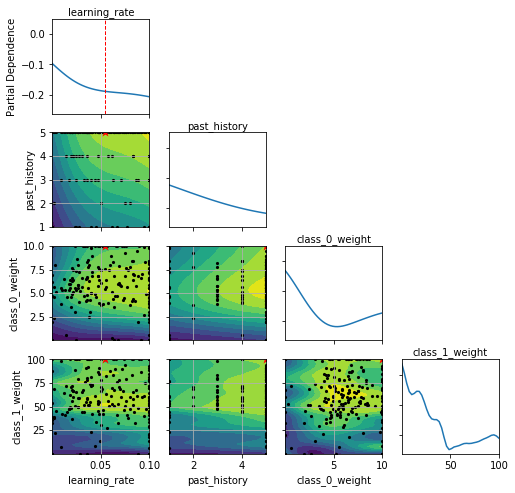

In [20]:
dim_names = [
    'learning_rate',
    'past_history',
    'class_0_weight',
    'class_1_weight'
]

fig, ax = plot_objective(result=search_result, dimension_names=dim_names)

### Take the winning hyperparameters and conduct a long training run. This is our 'Cassandra' model. It represents the upper bound - how well can the output be modeled from the input?

In [21]:
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

{'learning_rate': 0.053789338482071354,
 'past_history': 5,
 'class_0_weight': 10.0,
 'class_1_weight': 100.0}

In [22]:
learning_rate = winning_hyperparams['learning_rate']
past_history = winning_hyperparams['past_history']
class_0_weight = winning_hyperparams['class_0_weight']
class_1_weight = winning_hyperparams['class_1_weight']

class_weight = {0: class_0_weight, 1: class_1_weight}
#class_weight = [class_0_weight, class_1_weight]

EPOCHS = 350
batch_size = int((len(training_data) * 0.99) // past_history)
steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
validation_steps = int((len(validation_data) * 0.99) // batch_size)

In [23]:
x_train, y_train = data_functions.multivariate_data(
    training_data,
    past_history,
    future_target, 
    step
)

start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
end_index = x_train.shape[0]
x_train = np.delete(x_train, range(start_index, end_index), axis=0)
y_train = np.delete(y_train, range(start_index, end_index), axis=0)

x_validation, y_validation = data_functions.multivariate_data(
    validation_data,
    past_history,
    future_target, 
    step
)

start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
end_index = x_validation.shape[0]
x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

x_test, y_test = data_functions.multivariate_data(
    test_data,
    past_history,
    future_target, 
    step
)

start_index = (x_test.shape[0] - (x_test.shape[0] % batch_size))
end_index = x_test.shape[0]
x_test = np.delete(x_test, range(start_index, end_index), axis=0)
y_test = np.delete(y_test, range(start_index, end_index), axis=0)

input_dim = x_test.shape[-2:]
input_shape = (batch_size, input_dim[0], input_dim[1])

In [24]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    100,
    batch_input_shape = input_shape,
    stateful = True
))

model.add(tf.keras.layers.Dense(
    1,
    activation = 'sigmoid',
    bias_initializer = output_bias)
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = metrics
)

In [25]:
log_dir = f'./LSTM_logs/single_statefull_optimization_round1/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    x_train,
    y_train,
    epochs = EPOCHS,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    callbacks = [tensorboard_callback],
    validation_data = (x_validation, y_validation),
    validation_steps = validation_steps,
    class_weight = class_weight,
    workers = 8,
    verbose = 0
)

Total observations: 3287


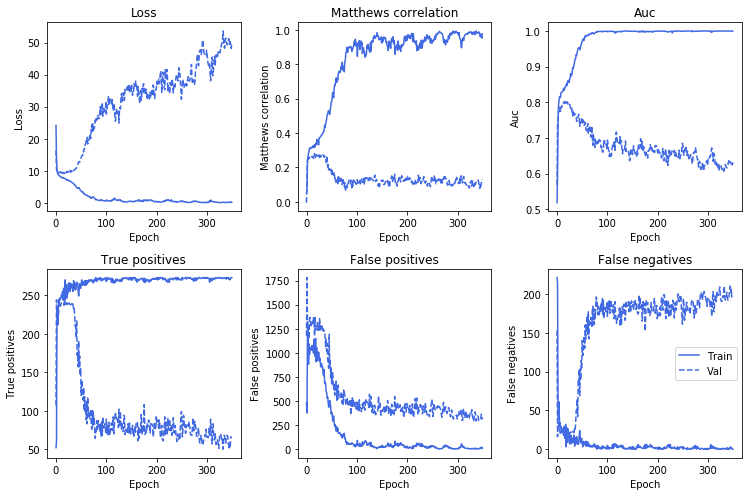

In [26]:
metric_names =  ['loss', 'matthews_correlation', 'auc', 'true_positives', 'false_positives', 'false_negatives']
filename = '../project_info/figures/single_LSTM_cassandra_learning_curves.png'
print(f"Total observations: {len(training_data)}")
plotting_functions.plot_metrics(history, metric_names, filename)

In [27]:
train_predictions = model.predict(x_train)
validation_predictions = model.predict(x_validation)
test_predictions = model.predict(x_test)

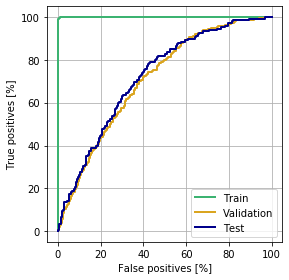

In [28]:
plotting_functions.plot_roc("Train", y_train, train_predictions, color='mediumseagreen')
plotting_functions.plot_roc("Validation", y_validation, validation_predictions, color='goldenrod')
plotting_functions.plot_roc("Test", y_test, test_predictions, color='darkblue')
plt.legend(loc='lower right')
plt.savefig('../project_info/figures/single_LSTM_cassandra_ROC.png', bbox_inches='tight')
plt.show()

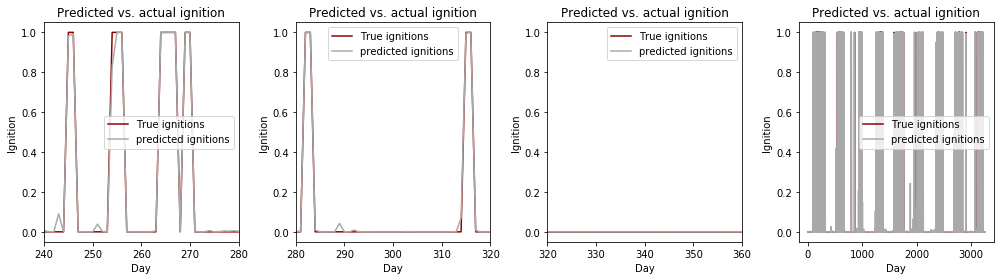

In [29]:
filename = '../project_info/figures/single_LSTM_cassandra_training_predictions.png'
plotting_functions.plot_ignition_predictions(train_predictions, y_train, filename)

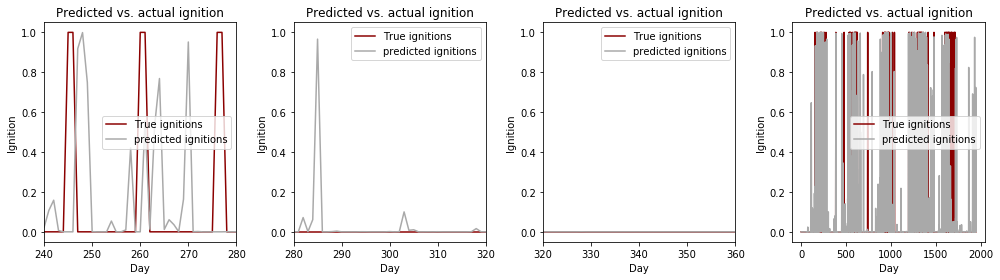

In [30]:
filename = '../project_info/figures/single_LSTM_cassandra_test_predictions.png'
plotting_functions.plot_ignition_predictions(test_predictions, y_test, filename)

loss :  0.007511337008327246
true_positives :  273.0
false_positives :  6.0
true_negatives :  2971.0
false_negatives :  0.0
auc :  0.9999889
matthews_correlation :  0.98740685
No fire (True Negatives):  2969
False alarms (False Positives):  8
Fires missed (False Negatives):  2
Fires detected (True Positives):  271
Total fires:  273


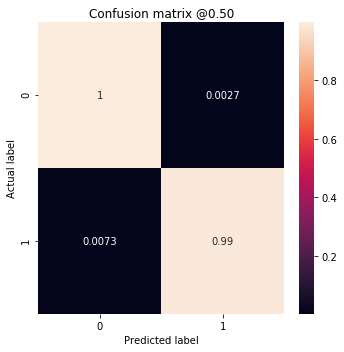

In [31]:
results = model.evaluate(
    x_train,
    y_train, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
    
filename = '../project_info/figures/single_LSTM_cassandra_training_confusion_matrix.png'
plotting_functions.plot_cm(y_train, train_predictions, filename)

loss :  0.7431667447090149
true_positives :  33.0
false_positives :  148.0
true_negatives :  1653.0
false_negatives :  116.0
auc :  0.6507291
matthews_correlation :  0.123671405
No fire (True Negatives):  1650
False alarms (False Positives):  151
Fires missed (False Negatives):  118
Fires detected (True Positives):  31
Total fires:  149


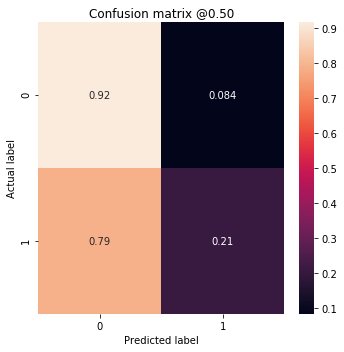

In [32]:
results = model.evaluate(
    x_test,
    y_test, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
    
filename = '../project_info/figures/single_LSTM_cassandra_test_confusion_matrix.png'
plotting_functions.plot_cm(y_test, test_predictions, filename)

### To improve generalizability we will run a second Gaussian process minimization.
1. Number of LSTM units will be added as a tunable parameter
2. Variational dropout will be added to the LSTM units as a tunable parameter
3. Gaussian optimization and early stopping will use Matthews correlation on the validation set rather than the training set

In [33]:
future_target = 1
step = 1

EPOCHS = 100

path_best_model = './trained_models/second_round_single_LSTM_optimization.keras'
best_val_matthews_correlation = -1.0

dim_learning_rate = Real(
    low = 0.0001,
    high = 0.1, 
    name = 'learning_rate'
)

dim_lstm_units = Integer(
    low=1, 
    high=10,
    name='lstm_units'
)

dim_variational_dropout = Real(
    low=0.01, 
    high=0.5,
    name='variational_dropout'
)

default_parameters = [learning_rate, 1, 0.1]

dimensions = [
    dim_learning_rate,
    dim_lstm_units,
    dim_variational_dropout
]

# Use early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_matthews_correlation', 
    patience = 10,
    mode = 'max',
    restore_best_weights = True
)

run_num = 1

In [34]:
def make_model(
        input_shape,
        learning_rate,
        lstm_units,
        variational_dropout,
):    
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(
        lstm_units,
        batch_input_shape = input_shape,
        dropout = variational_dropout,
        stateful = True
    ))
    
    model.add(tf.keras.layers.Dense(
        1,
        activation = 'sigmoid',
        bias_initializer = output_bias)
    )

    model.compile(
        optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
        loss = keras.losses.BinaryCrossentropy(),
        metrics = metrics
    )

    return model

@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
    lstm_units,
    variational_dropout
):
    
    batch_size = int((len(training_data) * 0.99) // past_history)
    steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
    validation_steps = int((len(validation_data) * 0.99) // batch_size)
    
    # create data stream
    x_train, y_train = data_functions.multivariate_data(
        training_data,
        past_history,
        future_target, 
        step
    )
    
    x_validation, y_validation = data_functions.multivariate_data(
        validation_data,
        past_history,
        future_target, 
        step
    )
    
    start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
    end_index = x_train.shape[0]
    
    x_train = np.delete(x_train, range(start_index, end_index), axis=0)
    y_train = np.delete(y_train, range(start_index, end_index), axis=0)
    
    start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
    end_index = x_validation.shape[0]
    
    x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
    input_dim = x_train.shape[-2:]
    input_shape = (batch_size, input_dim[0], input_dim[1])
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        input_shape = input_shape,
        learning_rate = learning_rate,
        lstm_units = lstm_units,
        variational_dropout = variational_dropout,
    )
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    global run_num
    
    log_dir = f'./LSTM_logs/single_statefull_gp_min_run{run_num}/'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
   
    # Use Keras to train the model.
    history = model.fit(
        x_train,
        y_train,
        epochs = EPOCHS,
        batch_size = batch_size,
        steps_per_epoch = steps_per_epoch,
        #callbacks = [early_stopping_callback],
        validation_data = (x_validation, y_validation),
        validation_steps = validation_steps,
        class_weight = class_weight,
        workers = 8,
        verbose=0
    )

    val_matthews_correlation = history.history['val_matthews_correlation'][-1]
    
    run_num += 1

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_val_matthews_correlation

    # If the classification accuracy of the saved model is improved ...
    if val_matthews_correlation > best_val_matthews_correlation:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_val_matthews_correlation = val_matthews_correlation
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -val_matthews_correlation

In [ ]:
%%time

search_result = gp_minimize(
    func = fitness,
    dimensions = dimensions,
    acq_func = 'EI', # Expected Improvement.
    n_calls = 200,
    x0 = default_parameters
)

In [ ]:
dim_names = [
    'learning_rate',
    'lstm_units',
    'variational_dropout'
]

fig, ax = plot_objective(result = search_result, dimension_names = dim_names)

In [ ]:
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

In [ ]:
# hyperparameters
learning_rate = winning_hyperparams['learning_rate']
lstm_units = winning_hyperparams['lstm_units']
variational_dropout = winning_hyperparams['variational_dropout']
#dropout_layer_rate = 0.5

EPOCHS = 500
batch_size = int((len(training_data) * 0.99) // past_history)
steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
validation_steps = int((len(validation_data) * 0.99) // batch_size)

In [ ]:
print(f'Past history {past_history}')
print(f'Batch size: {batch_size}')
print(f'Steps per epoch: {steps_per_epoch}')

In [ ]:
x_train, y_train = data_functions.multivariate_data(
    training_data,
    past_history,
    future_target, 
    step
)

start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
end_index = x_train.shape[0]
x_train = np.delete(x_train, range(start_index, end_index), axis=0)
y_train = np.delete(y_train, range(start_index, end_index), axis=0)

x_validation, y_validation = data_functions.multivariate_data(
    validation_data,
    past_history,
    future_target, 
    step
)

start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
end_index = x_validation.shape[0]
x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

x_test, y_test = data_functions.multivariate_data(
    test_data,
    past_history,
    future_target, 
    step
)

start_index = (x_test.shape[0] - (x_test.shape[0] % batch_size))
end_index = x_test.shape[0]
x_testing = np.delete(x_test, range(start_index, end_index), axis=0)
y_testing = np.delete(y_test, range(start_index, end_index), axis=0)

input_dim = x_testing.shape[-2:]
input_shape = (batch_size, input_dim[0], input_dim[1])

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    lstm_units,
    batch_input_shape = input_shape,
    dropout = variational_dropout,
    stateful = True
))

# model.add(tf.keras.layers.Dropout(
#     dropout_layer_rate
# ))

model.add(tf.keras.layers.Dense(
    1,
    activation = 'sigmoid',
    bias_initializer = output_bias)
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = metrics
)

In [ ]:
%%time

history = model.fit(
    x_train,
    y_train,
    epochs = EPOCHS,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    #callbacks = [early_stopping_callback],
    validation_data = (x_validation, y_validation),
    validation_steps = validation_steps,
    class_weight = class_weight,
    workers = 8,
    verbose = 0
)

In [ ]:
metric_names =  ['loss', 'matthews_correlation', 'true_positives', 'false_positives', 'true_negatives', 'false_negatives']
filename = '../project_info/figures/single_LSTM_optimized_learning_curves.png'
print(f"Total observations: {len(training_data)}")
plotting_functions.plot_metrics(history, metric_names, filename)

In [ ]:
train_predictions = model.predict(x_train)
validation_predictions = model.predict(x_validation)
test_predictions = model.predict(x_testing)

In [ ]:
plotting_functions.plot_roc("Train", y_train, train_predictions, color='darkgray')
plotting_functions.plot_roc("Validation", y_validation, validation_predictions, color='goldenrod')
plotting_functions.plot_roc("Test", y_testing, test_predictions, color='darkblue')
plt.legend(loc='lower right')
plt.show()

In [ ]:
filename = '../project_info/figures/single_LSTM_optimized_training_predictions.png'
plotting_functions.plot_ignition_predictions(train_predictions, y_train, filename)

In [ ]:
filename = '../project_info/figures/single_LSTM_optimized_testing_predictions.png'
plotting_functions.plot_ignition_predictions(test_predictions, y_testing, filename)

In [ ]:
results = model.evaluate(
    x_train,
    y_train, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

filename = '../project_info/figures/single_LSTM_optimized_training_confusion_matrix.png'
plotting_functions.plot_cm(y_train, train_predictions, filename)

In [ ]:
results = model.evaluate(
    x_testing,
    y_testing, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

filename = '../project_info/figures/single_LSTM_optimized_testing_confusion_matrix.png'
plotting_functions.plot_cm(y_testing, test_predictions, filename)